In [1]:
# Import the necessary libraries
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage
from spectral import *
from scipy.io import loadmat

In [2]:
# import os
# import tensorflow
#
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# print("is_gpu_available: \n", tensorflow.test.is_gpu_available())
# # print("is_gpu_available: \n", tensorflow.config.list_physical_devices('GPU'))

In [3]:
import os

os.chdir("/root/autodl-tmp/")

In [4]:
PATH = os.getcwd()
print(PATH)

/root/autodl-tmp


In [5]:
Salinas_corrected = loadmat('data/Salinas_corrected.mat')
Salinas_gt = loadmat('data/Salinas_gt.mat')
print(Salinas_corrected.keys())
print(Salinas_gt.keys())

dict_keys(['__header__', '__version__', '__globals__', 'salinas_corrected'])
dict_keys(['__header__', '__version__', '__globals__', 'salinas_gt'])


In [6]:
print(np.unique(Salinas_gt['salinas_gt']))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [7]:
#  load the Indian pines dataset which is the .mat format
def loadSalinas_correctedData():
	data_path = os.path.join(os.getcwd(), 'data')
	data = sio.loadmat(os.path.join(data_path,
	                                'Salinas_corrected.mat'))['salinas_corrected']
	labels = sio.loadmat(os.path.join(data_path,
	                                  'Salinas_gt.mat'))['salinas_gt']

	return data, labels

In [8]:
#  split data to Train and Test Set
def splitTrainTestSet(X, y, classnum=16, testRatio=0.50):
	# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testRatio, random_state=345, stratify=y)
	ss = StratifiedShuffleSplit(n_splits=classnum, test_size=testRatio, train_size=1 - testRatio, random_state=0)
	# print(classnum)
	# print(testRatio)
	for train_index, test_index in ss.split(X, y):
		print("TRAIN:", train_index, "TEST:", test_index)
		X_train, X_test = X[train_index], X[test_index]
		y_train, y_test = y[train_index], y[test_index]

	return X_train, X_test, y_train, y_test

In [9]:
#  over sample
def oversampleWeakClasses(X, y):
	uniqueLabels, labelCounts = np.unique(y, return_counts=True)
	maxCount = np.max(labelCounts)
	labelInverseRatios = maxCount / labelCounts
	# repeat for every label and concat
	newX = X[y == uniqueLabels[0], :].repeat(round(labelInverseRatios[0]), axis=0)
	newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
	for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
		cX = X[y == label, :].repeat(round(labelInverseRatio), axis=0)
		cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
		newX = np.concatenate((newX, cX))
		newY = np.concatenate((newY, cY))
	np.random.seed(seed=42)
	rand_perm = np.random.permutation(newY.shape[0])
	newX = newX[rand_perm, :, :, :]
	newY = newY[rand_perm]
	return newX, newY

In [10]:
#  split data to Train and Test Set
def splitTrainTestSet(X, y, classnum=16, testRatio=0.50):
	#     X_train, X_test, y_train, y_test = train_test_split(X, y,
	#                                test_size=testRatio, random_state=345, stratify=y)
	ss = StratifiedShuffleSplit(n_splits=classnum, test_size=testRatio,
	                            train_size=1 - testRatio, random_state=0)
	# print(classnum)
	# print(testRatio)
	for train_index, test_index in ss.split(X, y):
		print("TRAIN:", train_index, "TEST:", test_index)
		X_train, X_test = X[train_index], X[test_index]
		y_train, y_test = y[train_index], y[test_index]

	return X_train, X_test, y_train, y_test

In [11]:
#  standartize
def standartizeData(X):
	newX = np.reshape(X, (-1, X.shape[2]))
	scaler = preprocessing.StandardScaler().fit(newX)
	newX = scaler.transform(newX)
	newX = np.reshape(newX, (X.shape[0], X.shape[1], X.shape[2]))
	return newX, scaler

In [12]:
#  apply PCA preprocessing for data sets
def applyPCA(X, numComponents=30):
	newX = np.reshape(X, (-1, X.shape[2]))
	pca = PCA(n_components=numComponents, whiten=True)
	newX = pca.fit_transform(newX)
	newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
	return newX, pca

In [13]:
# #  上下左右各补margin个0
def padWithZeros(X, margin=2):
	newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2 * margin, X.shape[2]))
	x_offset = margin
	y_offset = margin
	newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
	return newX

In [14]:
#  create Patches for dataset
#  N: batch;
#  C: channel
#  H: height
#  W: width
#  Tensorflow的tensor通道顺序：默认是NHWC， 也支持NCHW
#  (batch_size, height, width, channels)
def createPatches(X, y, windowSize=5, removeZeroLabels=True):
	margin = int((windowSize - 1) / 2)
	zeroPaddedX = padWithZeros(X, margin=margin)
	# split patches
	patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
	patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
	patchIndex = 0
	for r in range(margin, zeroPaddedX.shape[0] - margin):
		for c in range(margin, zeroPaddedX.shape[1] - margin):
			patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
			patchesData[patchIndex, :, :, :] = patch
			patchesLabels[patchIndex] = y[r - margin, c - margin]
			patchIndex = patchIndex + 1
	if removeZeroLabels:
		patchesData = patchesData[patchesLabels > 0, :, :, :]
		patchesLabels = patchesLabels[patchesLabels > 0]
		patchesLabels -= 1
	return patchesData, patchesLabels

In [15]:
#  Augment Data
def AugmentData(X_train):
	for i in range(int(X_train.shape[0] / 2)):
		patch = X_train[i, :, :, :]
		num = random.randint(0, 2)
		if (num == 0):
			flipped_patch = np.flipud(patch)
		if (num == 1):
			flipped_patch = np.fliplr(patch)
		if (num == 2):
			no = random.randrange(-180, 180, 30)
			flipped_patch = scipy.ndimage.interpolation.rotate(patch, no, axes=(1, 0), reshape=False, output=None,
			                                                   order=3, mode='constant', cval=0.0, prefilter=False)
	patch2 = flipped_patch
	X_train[i, :, :, :] = patch2

	return X_train

In [16]:
# save Preprocessed Data to file
def savePreprocessedData(path, X_trainPatches, X_testPatches, y_trainPatches,
                         y_testPatches, X_all, y_all, windowSize, wasPCAapplied=False,
                         numPCAComponents=0, testRatio=0.25):
	# os.mkdir(os.path.join(os.getcwd(), path))
	data_path = os.path.join(os.getcwd(), path)

	if wasPCAapplied:
		with open(os.path.join(data_path, "XtrainWindowSize") + str(windowSize) +
		          "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, X_trainPatches)
		with open(os.path.join(data_path, "XtestWindowSize") + str(windowSize) +
		          "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, X_testPatches)
		with open(os.path.join(data_path, "ytrainWindowSize") + str(windowSize) +
		          "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, y_trainPatches)
		with open(os.path.join(data_path, "ytestWindowSize") + str(windowSize) +
		          "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, y_testPatches)

		with open(os.path.join(data_path, "XAllWindowSize") + str(windowSize) +
		          "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, X_all)
		with open(os.path.join(data_path, "yAllWindowSize") + str(windowSize) +
		          "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, y_all)
	else:
		with open(os.path.join(data_path, "preXtrainWindowSize") + str(windowSize) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, X_trainPatches)
		with open(os.path.join(data_path, "preXtestWindowSize") + str(windowSize) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, X_testPatches)
		with open(os.path.join(data_path, "preytrainWindowSize") + str(windowSize) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, y_trainPatches)
		with open(os.path.join(data_path, "preytestWindowSize") + str(windowSize) +
		          ".npy", 'bw') as outfile:
			np.save(outfile, y_testPatches)

In [17]:
# Global Variables
# The number of principal components to be retained in the PCA algorithm,
# the number of retained features  n
numComponents = 30
# Patches windows size
windowSize = 9
# The proportion of Test sets
testRatio = 0.95

In [18]:
# import os

# os.chdir("/root/autodl-tmp/")
# PATH = os.getcwd()
# print(PATH)

In [19]:
# Load dataset from file and apply PCA
# X, y = loadHSIData()
X, y = loadSalinas_correctedData()
print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

Hyperspectral data shape:  (512, 217, 204)
Label shape:  (512, 217)


In [20]:
X, pca = applyPCA(X, numComponents=numComponents)
print('Data shape after PCA: ', X.shape)
print('Label shape: ', y.shape)

Data shape after PCA:  (512, 217, 30)
Label shape:  (512, 217)


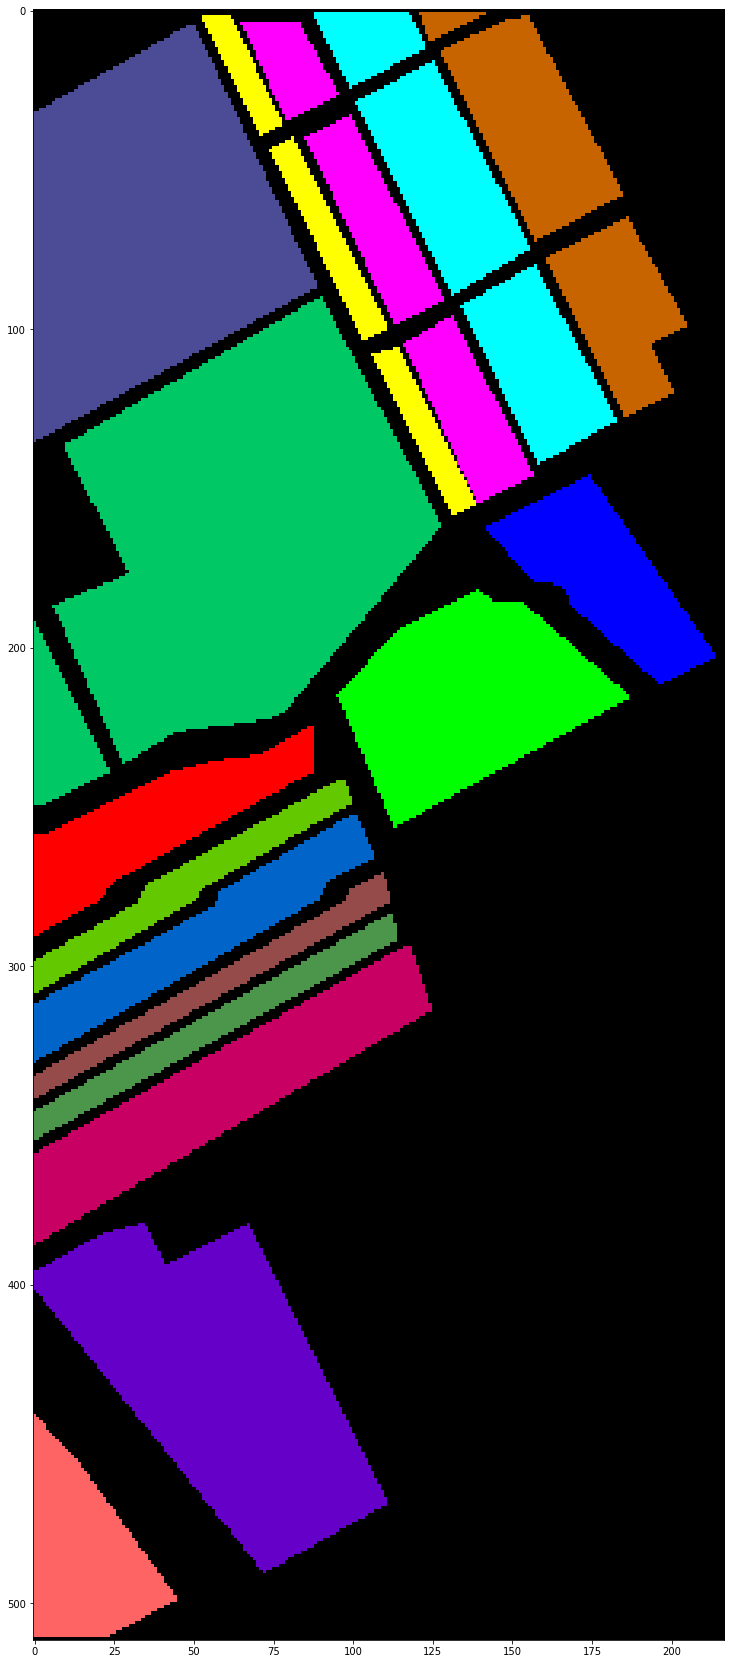

In [21]:
ground_truth = imshow(classes=y, figsize=(30, 30))

In [22]:
XPatches, yPatches = createPatches(X, y, windowSize=windowSize)
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, y.max() - y.min(), testRatio)
X_all = np.append(X_train, X_test, axis=0)
y_all = np.append(y_train, y_test, axis=0)
X_train, y_train = oversampleWeakClasses(X_train, y_train)
# X_all, y_all = oversampleWeakClasses(X_all, y_all)
X_train = AugmentData(X_train)
# X_all = AugmentData(X_all)

TRAIN: [40650 39314 21473 ... 20222 47511 34569] TEST: [ 3352 10906 27698 ...   277 31404 40115]
TRAIN: [15608 53347 45003 ... 29348 31088 47266] TEST: [ 7462  1762 35802 ...  4134 50091 18998]
TRAIN: [34974  4499 40891 ... 47415 35480 34032] TEST: [15635  1809 33204 ... 15299  2078 18092]
TRAIN: [  640 49223   946 ... 26609 40100 39648] TEST: [28688 18009 40969 ... 36027  9367 50722]
TRAIN: [29925 18901 44303 ...  2637 23133 45158] TEST: [30233 21926 31381 ... 25873 20563 38169]
TRAIN: [47097 47048 16664 ... 25733 22197 19533] TEST: [10000  8309 27336 ... 35030 43335 39208]
TRAIN: [27265 24261 40972 ... 36847 20445 52865] TEST: [25167 17287 40519 ... 16822 36731  1130]
TRAIN: [15103 22512  9562 ... 38313 32876 52286] TEST: [22970   811 41806 ... 11997   943 11631]
TRAIN: [38230 41168 26063 ... 31909 52064 10586] TEST: [49435 33882 45221 ... 19605 47017  3522]
TRAIN: [46776 51330 25554 ... 30778 41520  4009] TEST: [31363 53801 24175 ...  7931 18270 28652]
TRAIN: [ 8896 44658  3216 ... 

In [23]:
# print(XPatches.shape)
print('X_train shape: ', X_train.shape)
# print(yPatches.shape)
print('y_train shape: ', y_train.shape)
#  (batch_size, height, width, channels)
#  batch_size当成总的训练样本数，height和width图片的长宽，channels为图片的通道数，类似于彩色图片的rgb三通道
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (9172, 9, 9, 30)
y_train shape:  (9172,)
X_test shape:  (51423, 9, 9, 30)
y_test shape:  (51423,)


In [24]:
# save Preprocessed Data to file
savePreprocessedData('predata', X_train, X_test, y_train, y_test,
                     X_all, y_all, windowSize=windowSize,
                     wasPCAapplied=True, numPCAComponents=numComponents,
                     testRatio=testRatio)

In [25]:
# Import the necessary libraries
import numpy as np
import scipy
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
# K.set_image_dim_ordering('th')
# K.set_image_data_format('channels_first')  # 这个data_format参数是这样影响input_shape工作的如果不填写，默认是channels_last，否则可以填写channels_first。前者的会把input_shape这个三元组给识别成(batch_size, height, width, channels)，后者则会识别成(batch_size, channels, height, width)
from keras.utils import np_utils

2022-05-05 21:35:58.108026: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [26]:
# Global Variables
# The number of principal components to be retained in the PCA algorithm,
# the number of retained features  n
numPCAcomponents = 30
# Patches windows size
windowSize = 9
# The proportion of Test sets
testRatio = 0.95

In [27]:
X_train = np.load("./predata/XtrainWindowSize"
                  + str(windowSize) + "PCA" + str(numPCAcomponents) +
                  "testRatio" + str(testRatio) + ".npy")
y_train = np.load("./predata/ytrainWindowSize"
                  + str(windowSize) + "PCA" + str(numPCAcomponents) +
                  "testRatio" + str(testRatio) + ".npy")
X_test = np.load("./predata/XtestWindowSize"
                 + str(windowSize) + "PCA" + str(numPCAcomponents) +
                 "testRatio" + str(testRatio) + ".npy")
y_test = np.load("./predata/ytestWindowSize"
                 + str(windowSize) + "PCA" + str(numPCAcomponents) +
                 "testRatio" + str(testRatio) + ".npy")

In [28]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],
                               X_train.shape[2], X_train.shape[3]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],
                             X_test.shape[2], X_test.shape[3]))

# convert class labels to on-hot encoding
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# Define the input shape
input_shape = X_train[0].shape  # 也可再Conv2d中设置input_shape=input_shape[1:]
print('input shape: ', input_shape)

input shape:  (9, 9, 30)


In [29]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)

X_train shape:  (9172, 9, 9, 30)
y_train shape:  (9172, 16)


In [30]:
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

In [31]:
class BasicBlock(layers.Layer):
	expansion = 1

	def __init__(self, out_channel, strides=1, downsample=None, **kwargs):
		super(BasicBlock, self).__init__(**kwargs)
		self.out_channel = out_channel
		self.strides = strides
		self.conv1 = layers.Conv2D(out_channel, kernel_size=3, strides=strides,
		                           padding="SAME", use_bias=False)
		self.bn1 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
		# -----------------------------------------
		self.conv2 = layers.Conv2D(out_channel, kernel_size=3, strides=1,
		                           padding="SAME", use_bias=False)
		self.bn2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
		# -----------------------------------------
		self.downsample = downsample
		self.relu = layers.ReLU()
		self.add = layers.Add()

	def call(self, inputs, training=False):
		identity = inputs
		if self.downsample is not None:
			identity = self.downsample(inputs)

		x = self.conv1(inputs)
		x = self.bn1(x, training=training)
		x = self.relu(x)

		x = self.conv2(x)
		x = self.bn2(x, training=training)

		x = self.add([x, identity])
		x = self.relu(x)

		return x

	def get_config(self):
		config = super().get_config().copy()
		config.update({
			'out_channel': self.out_channel,
			'downsample': self.downsample,
			'strides': self.strides,
		})
		return config

# def get_config(self):
#     # 自定义层里面的属性
#     config = {
#         'out_channel': self.out_channel,
#         'downsample': self.downsample,
#         'strides': self.strides,
#     }
#     base_config = super(BasicBlock, self).get_config()
#     return dict(list(base_config.items()) + list(config.items()))

In [32]:
class Bottleneck(layers.Layer):
	"""
    注意：原论文中，在虚线残差结构的主分支上，第一个1x1卷积层的步距是2，第二个3x3卷积层步距是1。
    但在pytorch官方实现过程中是第一个1x1卷积层的步距是1，第二个3x3卷积层步距是2，
    这么做的好处是能够在top1上提升大概0.5%的准确率。
    可参考Resnet v1.5 https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch
    """
	expansion = 4

	def __init__(self, out_channel, strides=1, downsample=None, **kwargs):
		super(Bottleneck, self).__init__(**kwargs)
		self.out_channel = out_channel
		self.strides = strides
		self.conv1 = layers.Conv2D(out_channel, kernel_size=1, use_bias=False)
		self.bn1 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
		# -----------------------------------------
		self.conv2 = layers.Conv2D(out_channel, kernel_size=3, use_bias=False,
		                           strides=strides, padding="SAME", name="conv2")
		self.bn2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
		# -----------------------------------------
		self.conv3 = layers.Conv2D(out_channel * self.expansion, kernel_size=1, use_bias=False)
		self.bn3 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
		# -----------------------------------------
		self.relu = layers.ReLU()
		self.downsample = downsample
		self.add = layers.Add()

	def call(self, inputs, training=False):
		identity = inputs
		if self.downsample is not None:
			identity = self.downsample(inputs)

		x = self.conv1(inputs)
		x = self.bn1(x, training=training)
		x = self.relu(x)

		x = self.conv2(x)
		x = self.bn2(x, training=training)
		x = self.relu(x)

		x = self.conv3(x)
		x = self.bn3(x, training=training)

		x = self.add([x, identity])
		x = self.relu(x)

		return x

	def get_config(self):
		config = super().get_config().copy()
		config.update({
			'out_channel': self.out_channel,
			'downsample': self.downsample,
			'strides': self.strides,
		})
		return config

In [33]:
def _make_layer(block, in_channel, channel, block_num, strides=1):
	downsample = None
	if strides != 1 or in_channel != channel * block.expansion:
		downsample = Sequential([
			layers.Conv2D(channel * block.expansion, kernel_size=1, strides=strides,
			              use_bias=False),
			layers.BatchNormalization(momentum=0.9, epsilon=1.001e-5)
		])

	layers_list = []
	layers_list.append(block(channel, downsample=downsample, strides=strides))

	for index in range(1, block_num):
		layers_list.append(block(channel))

	return Sequential(layers_list)

In [34]:
def _resnet(block, blocks_num, im_width=224, im_height=224, num_classes=16, include_top=True):
	# tensorflow中的tensor通道排序是NHWC
	# (None, 224, 224, 3)
	input_image = layers.Input(shape=(im_height, im_width, 30), dtype="float32")
	x = layers.Conv2D(filters=64, kernel_size=7, strides=2,
	                  padding="SAME", use_bias=False)(input_image)
	x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
	x = layers.ReLU()(x)
	x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME")(x)

	x = _make_layer(block, x.shape[-1], 64, blocks_num[0])(x)
	x = _make_layer(block, x.shape[-1], 128, blocks_num[1], strides=2)(x)
	x = _make_layer(block, x.shape[-1], 256, blocks_num[2], strides=2)(x)
	x = _make_layer(block, x.shape[-1], 512, blocks_num[3], strides=2)(x)

	if include_top:
		x = layers.GlobalAvgPool2D()(x)  # pool + flatten
		x = layers.Dense(num_classes)(x)
		predict = layers.Softmax()(x)
	else:
		predict = x

	model = Model(inputs=input_image, outputs=predict)

	return model


def resnet34(im_width=224, im_height=224, num_classes=1000, include_top=True):
	return _resnet(BasicBlock, [3, 4, 6, 3], im_width, im_height, num_classes, include_top)


def resnet50(im_width=224, im_height=224, num_classes=1000, include_top=True):
	return _resnet(Bottleneck, [3, 4, 6, 3], im_width, im_height, num_classes, include_top)


def resnet101(im_width=224, im_height=224, num_classes=1000, include_top=True):
	return _resnet(Bottleneck, [3, 4, 23, 3], im_width, im_height, num_classes, include_top)

In [35]:
model = resnet34(im_width=9, im_height=9, num_classes=16, include_top=True)

2022-05-05 21:35:59.904851: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-05 21:35:59.973104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 715.34GiB/s
2022-05-05 21:35:59.973140: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-05 21:35:59.976509: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-05 21:35:59.976551: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-05-05 21:35:59.977649: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9, 9, 30)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 64)          94080     
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 64)          256       
_________________________________________________________________
re_lu (ReLU)                 (None, 5, 5, 64)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 64)          0         
_________________________________________________________________
sequential (Sequential)      (None, 3, 3, 64)          222720    
_________________________________________________________________
sequential_2 (Sequential)    (None, 2, 2, 128)         111872

In [37]:
# Define optimization and train method
# monitor：监测的值，可以是accuracy，val_loss,val_accuracy
# factor：缩放学习率的值，学习率将以lr = lr*factor的形式被减少
# patience：当patience个epoch过去而模型性能不提升时，学习率减少的动作会被触发
# mode：‘auto’，‘min’，‘max’之一 默认‘auto’就行
# epsilon：阈值，用来确定是否进入检测值的“平原区”
# cooldown：学习率减少后，会经过cooldown个epoch才重新进行正常操作
# min_lr：学习率最小值，能缩小到的下限
# verbose(bool)-如果为True，则为每次更新向stdout输出一条消息。默认值：False。

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=5, min_lr=0.000001, verbose=1)

# 该回调函数将在每个epoch后保存模型到filepath
# filepath，保存模型的路径，里面的占位符将会被epoch值和传入on_epoch_end的logs关键字所填入
# monitor：需要监视的值，通常为：val_accuracy 或 val_loss 或 accuracy 或 loss
# verbose：信息展示模式，0或1。为1表示输出epoch模型保存信息，默认为0表示不输出该信息，信息形如：
# Epoch 00001: val_acc improved from -inf to 0.49240, saving model to /xxx/checkpoint/model_001-0.3902.h5
# save_best_only：当设置为True时，将只保存在验证集上性能最好的模型
# mode：‘auto’，‘min’，‘max’之一，在save_best_only=True时决定性能最佳模型的评判准则，例如，当监测值为val_acc时，模式应为max，当检测值为val_loss时，模式应为min。在auto模式下，评价准则由被监测值的名字自动推断。
# save_weights_only：若设置为True，则只保存模型权重，否则将保存整个模型（包括模型结构，配置信息等）
# period：CheckPoint之间的间隔的epoch数

checkpointer = ModelCheckpoint(filepath="checkpoint.hdf5", verbose=1, save_best_only=False)
sgd = SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [38]:
# Start to train model
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, checkpointer],
                    shuffle=True)

2022-05-05 21:36:01.716970: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-05 21:36:01.719142: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2800110000 Hz


Epoch 1/50


2022-05-05 21:36:03.806161: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-05-05 21:36:04.358367: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2022-05-05 21:36:05.048827: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-05 21:36:05.552634: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-05-05 21:36:05.681785: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


287/287 [==============================] - 24s 68ms/step - loss: 0.3887 - accuracy: 0.8873 - val_loss: 0.1122 - val_accuracy: 0.9552

Epoch 00001: saving model to checkpoint.hdf5
Epoch 2/50
287/287 [==============================] - 18s 64ms/step - loss: 0.0970 - accuracy: 0.9688 - val_loss: 0.0942 - val_accuracy: 0.9665

Epoch 00002: saving model to checkpoint.hdf5
Epoch 3/50
287/287 [==============================] - 18s 63ms/step - loss: 0.0503 - accuracy: 0.9810 - val_loss: 0.0451 - val_accuracy: 0.9851

Epoch 00003: saving model to checkpoint.hdf5
Epoch 4/50
287/287 [==============================] - 18s 64ms/step - loss: 0.0327 - accuracy: 0.9893 - val_loss: 0.0427 - val_accuracy: 0.9853

Epoch 00004: saving model to checkpoint.hdf5
Epoch 5/50
287/287 [==============================] - 18s 63ms/step - loss: 0.0280 - accuracy: 0.9908 - val_loss: 0.0458 - val_accuracy: 0.9873

Epoch 00005: saving model to checkpoint.hdf5
Epoch 6/50
287/287 [==============================] - 18s 63m

In [39]:
# save the model with h5py
import h5py
from keras.models import load_model

model.save('./model/HSI_model_epochs100.h5')
print('Model saved.')
# model.save('model')

Model saved.


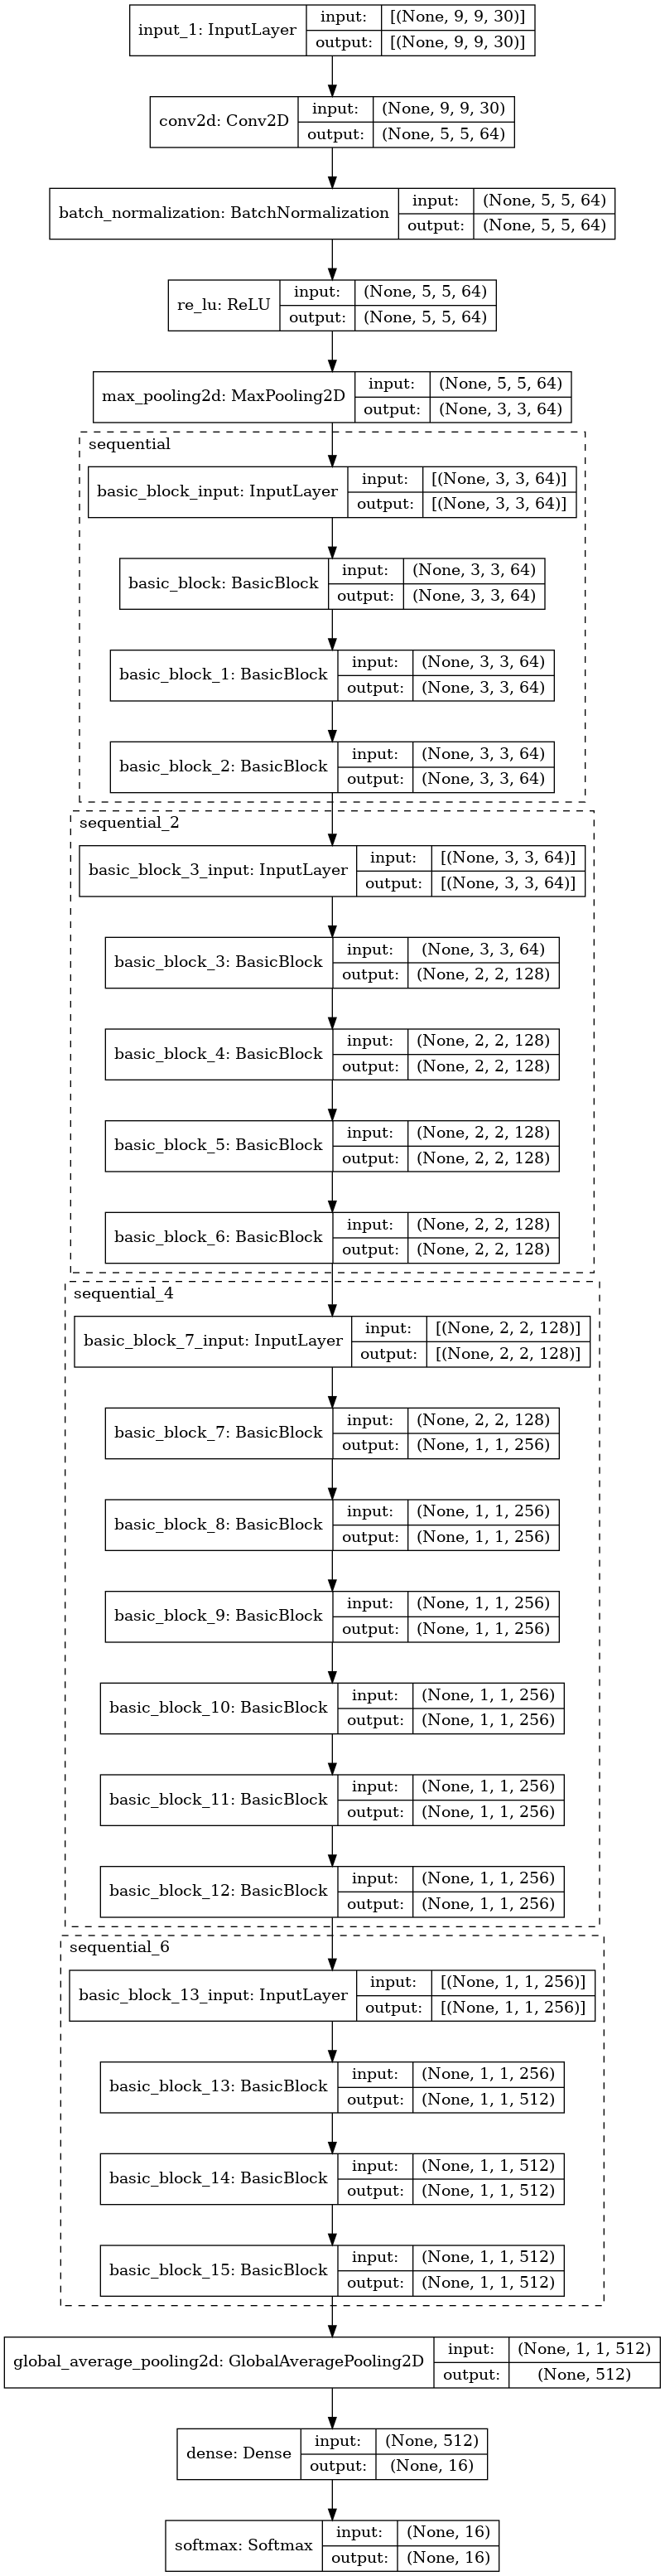

In [40]:
# using plot_model module to save the model figure
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='./model/model.png', show_shapes=True, show_layer_names=True, rankdir='TB',
           expand_nested=True)
# print(history.history.keys())

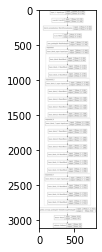

In [41]:
import matplotlib.pyplot as plt

# get_ipython().run_line_magic('matplotlib', 'inline')
model_img = plt.imread('./model/model.png')
plt.imshow(model_img)
plt.show()

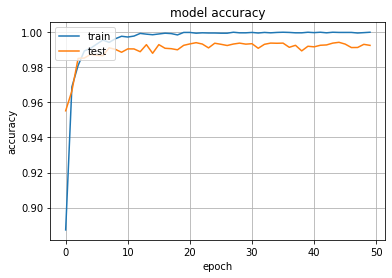

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left')
# os.mkdir(os.path.join(os.getcwd(), 'result'))
plt.savefig("./result/model_accuracy_100.svg")
plt.show()

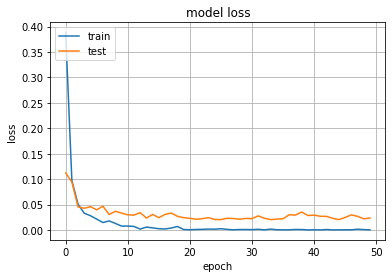

In [43]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./result/model_loss_100.svg")
plt.show()

In [44]:
# Import the necessary libraries
from sklearn.decomposition import PCA
import os
import scipy.io as sio
import numpy as np
from tensorflow.keras.models import load_model
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from tensorflow.keras.utils import get_custom_objects
import itertools
import spectral
from operator import truediv
from tqdm import tqdm

In [45]:
# Define the neccesary functions for later use
# load the Indian pines dataset which is the .mat format
def loadSalinas_correctedData():
	data_path = os.path.join(os.getcwd(), 'data')
	data = sio.loadmat(os.path.join(data_path,
	                                'Salinas_corrected.mat'))['salinas_corrected']
	labels = sio.loadmat(os.path.join(data_path,
	                                  'Salinas_gt.mat'))['salinas_gt']

	return data, labels

In [46]:
target_names = ['Baocoli_green_weeds_1', 'Baocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow',
                'Fallow_smooth', 'Stubble', 'Celery', 'Grapes_untrained', 'Soil_vinyard_develop',
                'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk', 'Lettuce_romaine_6wk',
                'Lettuce_romaine_7wk', 'Vinyard_untrained', 'Vinyard_treils']

In [47]:
def AA_andEachClassAccuracy(confusion_matrix):
	counter = confusion_matrix.shape[0]
	list_diag = np.diag(confusion_matrix)
	list_raw_sum = np.sum(confusion_matrix, axis=1)
	each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
	average_acc = np.mean(each_acc)
	return each_acc, average_acc

In [48]:
def reports(X_test, y_test):
	Y_pred = model.predict(X_test)
	y_pred = np.argmax(Y_pred, axis=1)

	classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names, digits=4)
	confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
	score = model.evaluate(X_test, y_test, batch_size=32)

	oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
	each_acc, aa = AA_andEachClassAccuracy(confusion)
	kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
	Test_Loss = score[0] * 100
	Test_accuracy = score[1] * 100
	oa = oa * 100
	each_acc = each_acc * 100
	aa = aa * 100
	kappa = kappa * 100
	return classification, confusion, Test_Loss, Test_accuracy, oa, each_acc, aa, kappa

In [49]:
def Patch(data, height_index, width_index):
	#transpose_array = data.transpose((2,0,1))
	#print transpose_array.shape
	margin = int((PATCH_SIZE - 1) / 2)
	zeroPaddedX = padWithZeros(data, margin=margin)
	height_slice = slice(height_index, height_index + PATCH_SIZE)
	width_slice = slice(width_index, width_index + PATCH_SIZE)
	patch = zeroPaddedX[height_slice, width_slice, :]

	return patch

In [50]:
# show current path
PATH = os.getcwd()
print(PATH)

/root/autodl-tmp


In [51]:
# Read PreprocessedData from file

X_test = np.load("./predata/XtestWindowSize"
                 + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")
y_test = np.load("./predata/ytestWindowSize"
                 + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")

# X_test = np.load("./predata/XAllWindowSize"
#                  + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")
# y_test = np.load("./predata/yAllWindowSize"
#                  + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3]))
y_test = np_utils.to_categorical(y_test)

In [52]:
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_test shape:  (51423, 9, 9, 30)
y_test shape:  (51423, 16)


In [53]:
# load the model architecture and weights
model = load_model('./model/HSI_model_epochs100.h5',
                   custom_objects={'BasicBlock': BasicBlock, 'Bottleneck': Bottleneck})

In [54]:
# calculate result, loss, accuray and confusion matrix
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(X_test, y_test)
classification = str(classification)
confusion_str = str(confusion)

# show result and save to file
print('Test loss {} (%)'.format(Test_loss))
print('Test accuracy {} (%)'.format(Test_accuracy))
print('Kappa accuracy {} (%)'.format(kappa))
print('Overall accuracy {} (%)'.format(oa))
print('Average accuracy {} (%)'.format(aa))
print("classification result: ")
print('{}'.format(classification))
print("confusion matrix: ")
print('{}'.format(confusion_str))
file_name = './result/report' + "WindowSize" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(
	testRatio) + ".txt"
with open(file_name, 'w') as x_file:
	x_file.write('Test loss {} (%)'.format(Test_loss))
	x_file.write('\n')
	x_file.write('Test accuracy {} (%)'.format(Test_accuracy))
	x_file.write('\n')
	x_file.write('Kappa accuracy {} (%)'.format(kappa))
	x_file.write('\n')
	x_file.write('Overall accuracy {} (%)'.format(oa))
	x_file.write('\n')
	x_file.write('Average accuracy {} (%)'.format(aa))
	x_file.write('\n')
	x_file.write('\n')
	x_file.write(" classification result: \n")
	x_file.write('{}'.format(classification))
	x_file.write('\n')
	x_file.write(" confusion matrix: \n")
	x_file.write('{}'.format(confusion_str))

1607/1607 [==============================] - 14s 8ms/step - loss: 0.0235 - accuracy: 0.9925
Test loss 2.35219094902277 (%)
Test accuracy 99.25130605697632 (%)
Kappa accuracy 99.16667790440484 (%)
Overall accuracy 99.25130778056511 (%)
Average accuracy 99.60732133322452 (%)
classification result: 
                           precision    recall  f1-score   support

    Baocoli_green_weeds_1     1.0000    1.0000    1.0000      1909
    Baocoli_green_weeds_2     1.0000    1.0000    1.0000      3540
                   Fallow     1.0000    1.0000    1.0000      1877
        Fallow_rough_plow     1.0000    0.9894    0.9947      1324
            Fallow_smooth     0.9945    1.0000    0.9973      2544
                  Stubble     0.9981    1.0000    0.9991      3761
                   Celery     1.0000    0.9979    0.9990      3400
         Grapes_untrained     0.9949    0.9734    0.9840     10707
     Soil_vinyard_develop     0.9998    1.0000    0.9999      5893
Corn_senesced_green_weeds     0

In [55]:
import matplotlib.pyplot as plt


# get_ipython().run_line_magic('matplotlib', 'inline')
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.get_cmap("Blues")):
	"""
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
	Normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
	if normalize:
		cm = Normalized
		print("Normalized confusion matrix")
	else:
		print('Confusion matrix, without normalization')

	print(cm)

	plt.imshow(Normalized, interpolation='nearest', cmap=cmap)
	plt.colorbar()
	plt.title(title)
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation=90)
	plt.yticks(tick_marks, classes)

	fmt = '.4f' if normalize else 'd'
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		thresh = cm[i].max() / 2.
		plt.text(j, i, format(cm[i, j], fmt),
		         horizontalalignment="center",
		         color="white" if cm[i, j] > thresh else "black")

	plt.tight_layout()
	plt.ylabel('True label')
	plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 1909     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0  3540     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0  1877     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0  1310    14     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0  2544     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0  3761     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     7  3393     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0 10422     0    17     0     0
      0     0   268     0]
 [    0     0     0     0     0     0     0     0  5893     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0  

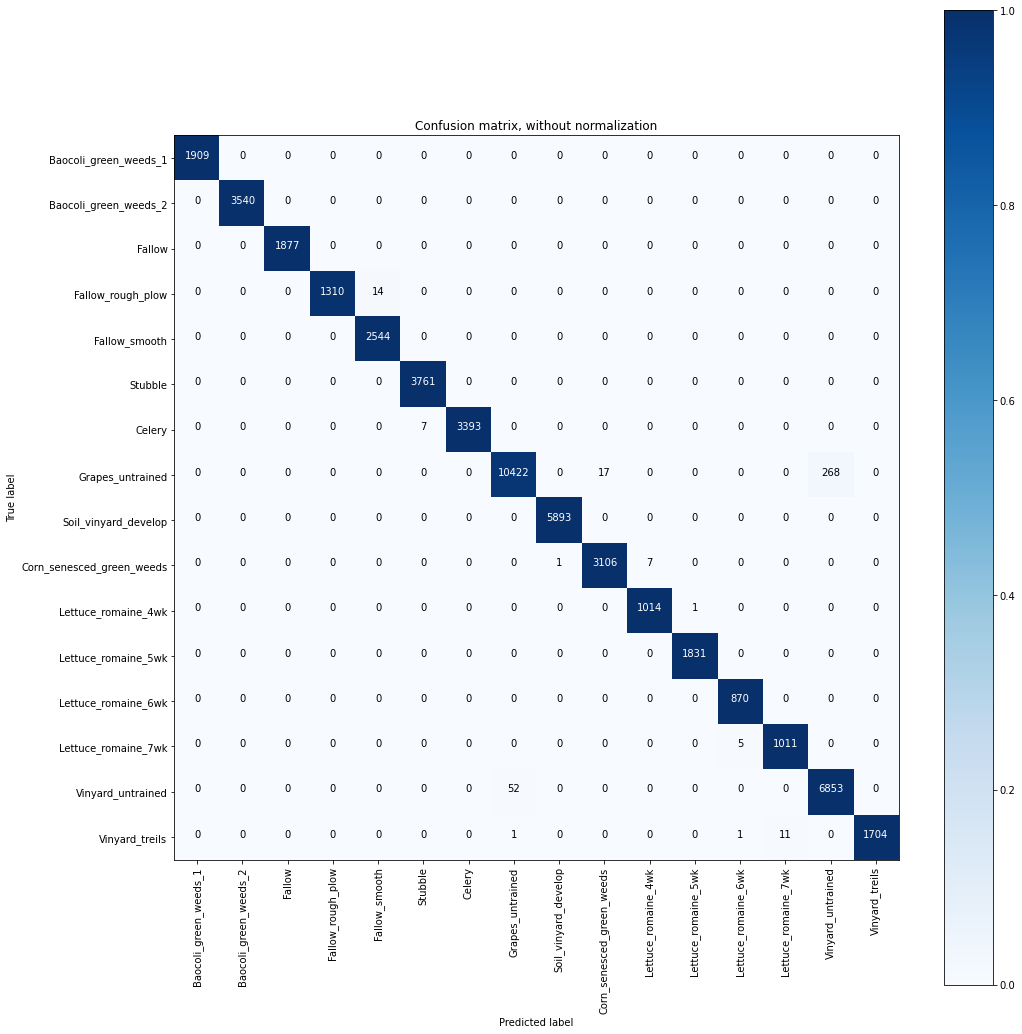

Normalized confusion matrix
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.89425982e-01
  1.05740181e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000

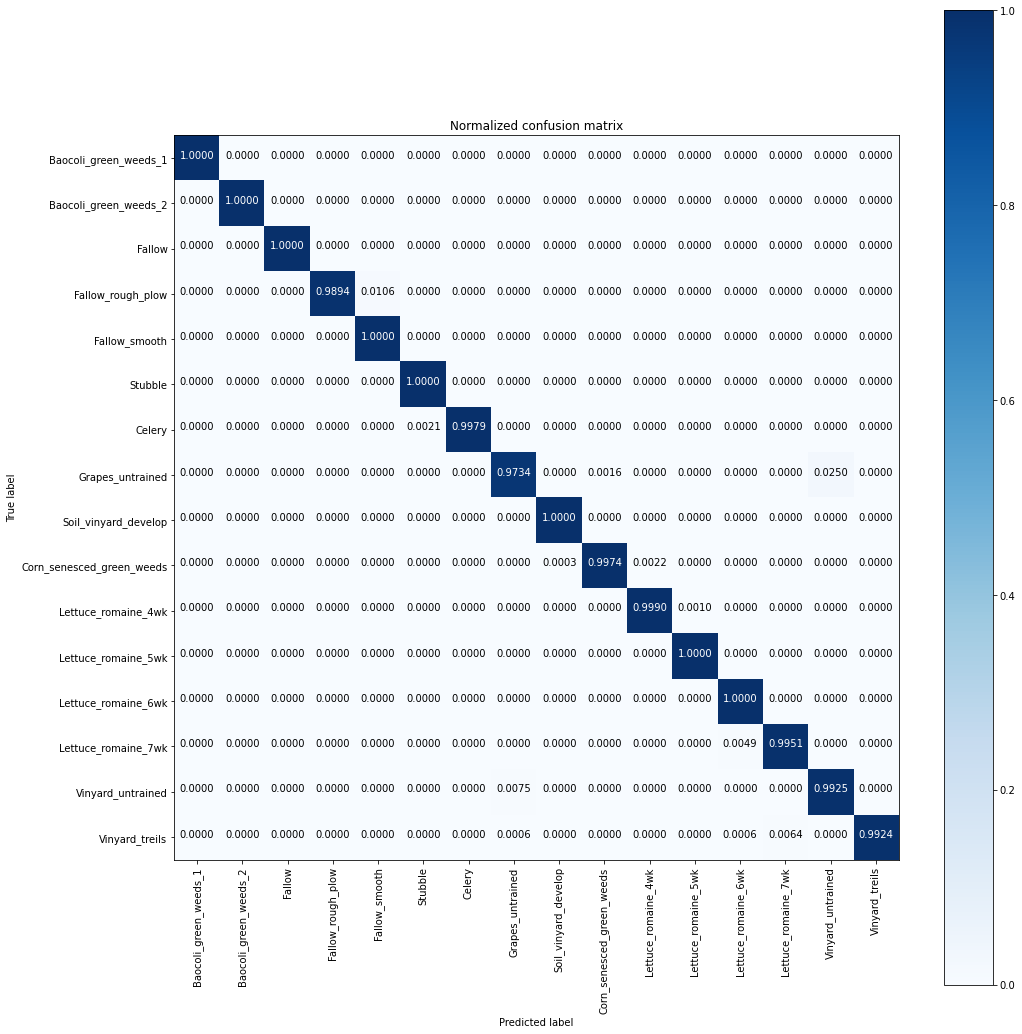

In [56]:
plt.figure(figsize=(15, 15))
plot_confusion_matrix(confusion, classes=target_names, normalize=False, title='Confusion matrix, without normalization')
plt.savefig("./result/confusion_matrix_without_normalization.svg")
plt.show()
plt.figure(figsize=(15, 15))
plot_confusion_matrix(confusion, classes=target_names, normalize=True, title='Normalized confusion matrix')
plt.savefig("./result/confusion_matrix_with_normalization.svg")
plt.show()

In [57]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = 9

In [58]:
print('X_shape: ', X.shape)
print('y_shape: ', y.shape)

X_shape:  (512, 217, 30)
y_shape:  (512, 217)


In [59]:
# calculate the predicted image
outputs = np.zeros((height, width))
for i in tqdm(range(height)):
	for j in range(width):
		target = y[i][j]
		if target == 0:
			continue
		else:
			image_patch = Patch(X, i, j)
			# print (image_patch.shape)
			X_test_image = image_patch.reshape(1, image_patch.shape[0], image_patch.shape[1],
			                                   image_patch.shape[2]).astype('float32')
			# print(X_test_image.shape)
			# prediction = np.argmax(model.predict(X_test_image),axis=1)
			prediction = model.predict(X_test_image)
			prediction = np.argmax(prediction, axis=1)
			# (model.predict_classes(X_test_image))
			outputs[i][j] = prediction + 1

100%|██████████| 512/512 [39:50<00:00,  4.67s/it]


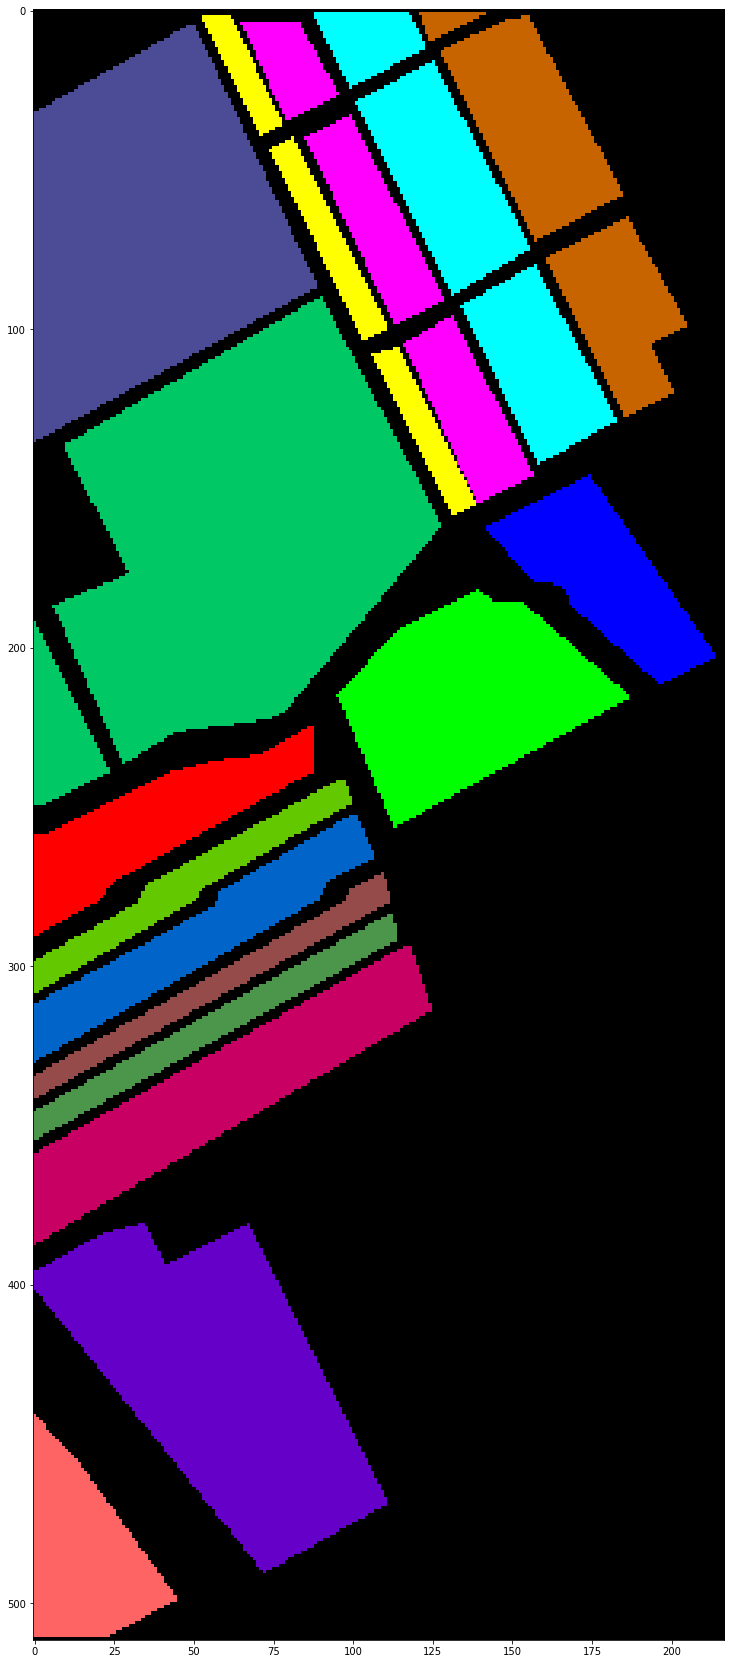

In [60]:
ground_truth = spectral.imshow(classes=y, figsize=(30, 30))

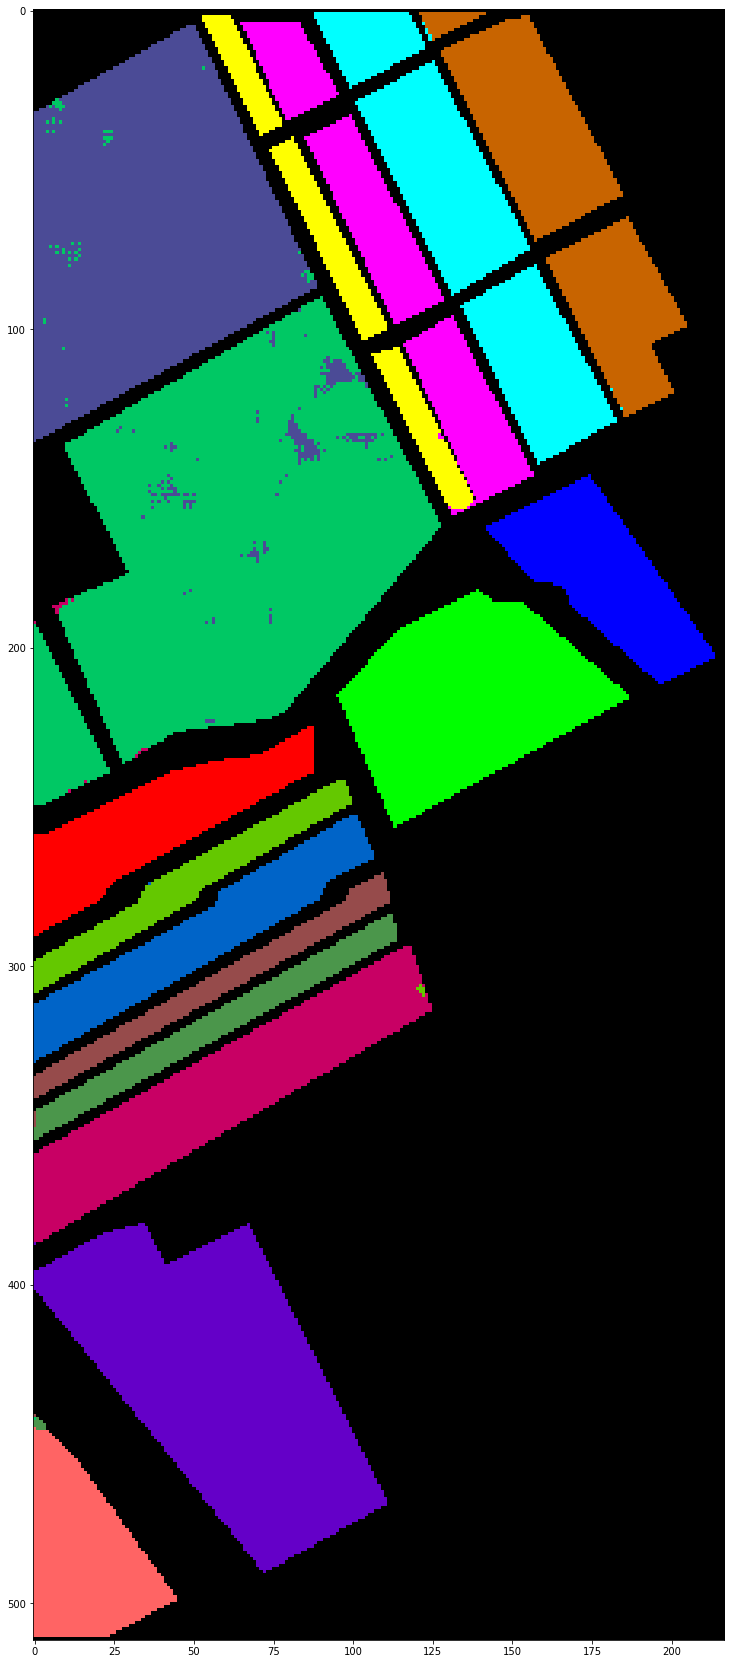

In [61]:
predict_image = spectral.imshow(classes=outputs.astype(int), figsize=(30, 30))